# O-List Ecommerce Data EDA

O-List is the largest ecommerce platform in Brazil. In this EDA, we explore a dataset containing real anonymized ecommerce data sampled from O-List, made available on Kaggle. The dataset contains data on 100,000 orders between 2016 and 2018. The data is organized into seperate tables:

>Customers  
>Geolocation  
>Items sold  
>Payments  
>Reviews  
>Orders  
>Products  
>Sellers  
>Product category  

There is also a seperate dataset containing marketing funnel data, which allows us to see the entire seller onboarding process, from funnel entry to deal close.

_**Note: All currencies are in BRL (Brazilian Real)**_

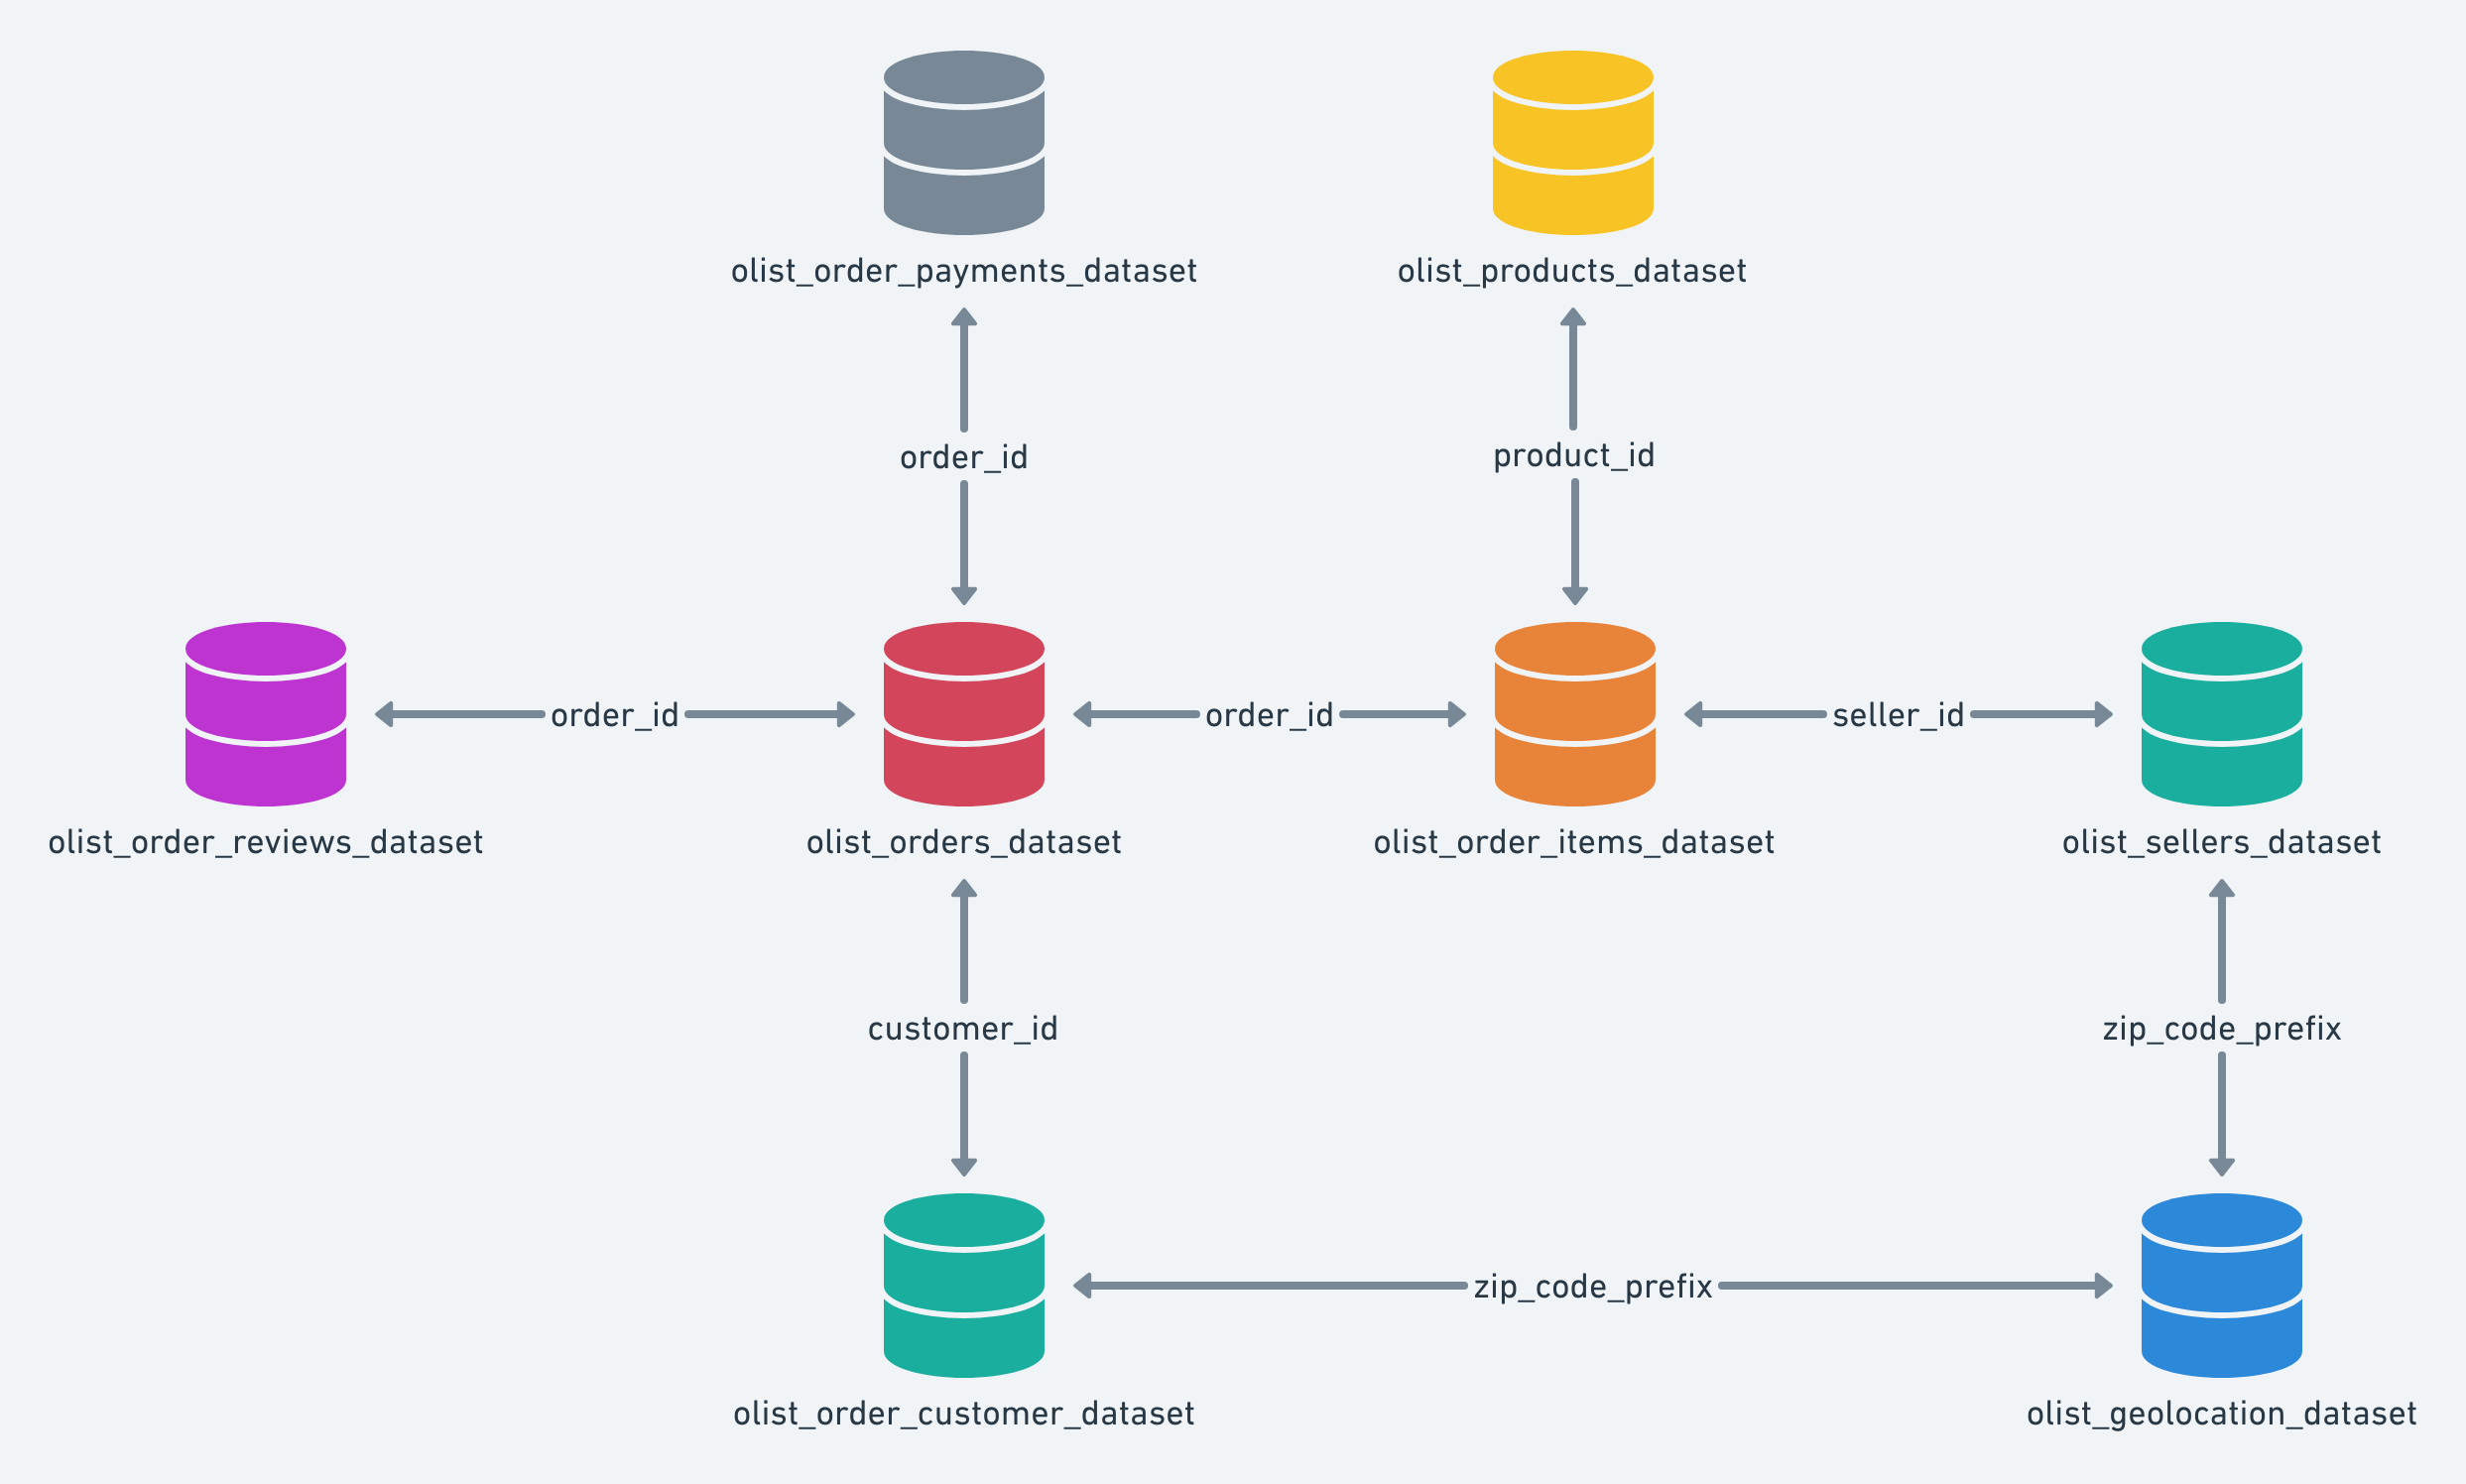

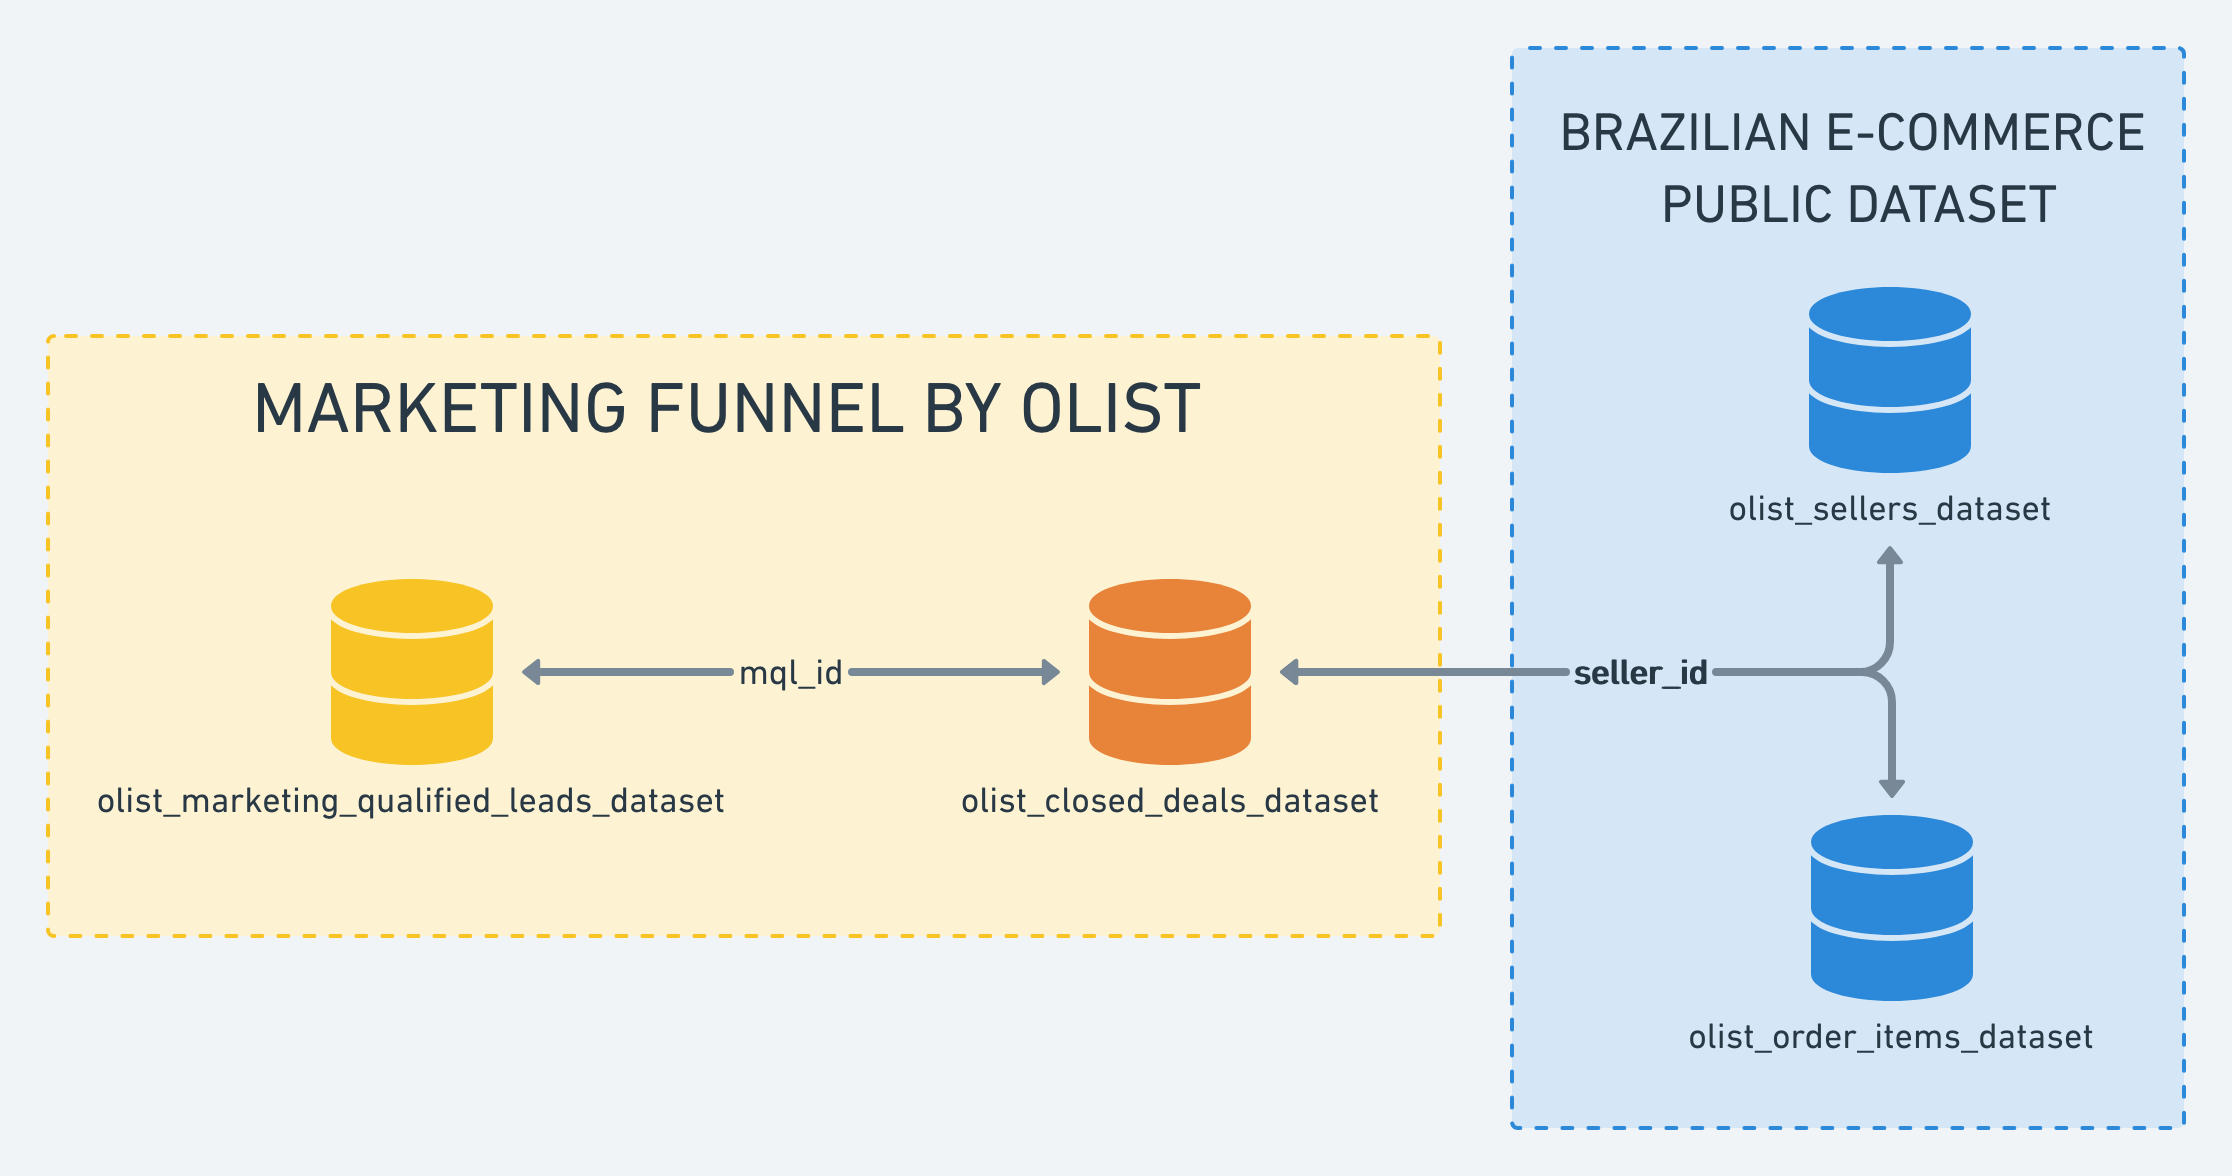

## Questions

**Sales**
>What do we see when observing total net sales?

**Products**
>What are the top categories in terms of sales?  
>Are there any categories that stand out in terms of growth?     

**Customers**
>What is the distribution of order totals?  
>What can we learn about repeat customers?   

**Sellers and Marketing**
>How has the seller base grown over time?  
>What can we learn about O-List marketing and its success in onboarding new sellers? 



In [1]:
#Standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

pd.options.mode.chained_assignment = None

First, I'll bring in datasets

In [2]:
payments = pd.read_csv('olist_order_payments_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
#I'll create separate DF's for seller and customer geo, for later analysis
sellers_geo = pd.read_csv('olist_geolocation_dataset.csv')
cust_geo = pd.read_csv('olist_geolocation_dataset.csv')
closed_deals = pd.read_csv('olist_closed_deals_dataset.csv')
mql = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')

In [3]:
#Lambda expressions rename zip_code columns for the purpose of later joining with geo dataset
sellers_geo.rename(columns = lambda x: x.replace("geolocation","seller"), inplace=True)
cust_geo.rename(columns = lambda x: x.replace("geolocation","customer"), inplace=True)

I'll structure the data by creating a master table for use in answering product, customers and sellers questions

In [4]:
df = pd.merge(orders, customers, on = 'customer_id', how = 'outer')
df = df.merge(items, on = "order_id", how = 'outer')
df = df.merge(products, on = 'product_id', how = 'outer')
df = df.merge(sellers, on = 'seller_id', how = 'outer')

Does the dataframe need cleaning?

In [5]:
#Any duplicate rows?
df[df.duplicated() == True]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state


In [6]:
#Any rows missing key data?
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
product_category_name            2378
product_name_lenght              2378
product_description_lenght       2378
product_photos_qty               2378
product_weight_g                  793
product_length_cm                 793
product_height_cm                 793
product_width_cm                  793
seller_zip_c

There are NaN values in columns that are key to the questions we hope to answer, namely product_id and product_category. Given that we'll retain 96% of rows if we remove NaN, I'll drop rows with NaN values, and we still have insights that are directionally accurate.

In [7]:
df.dropna(axis = 0, inplace=True)

Do any columns need dtype conversion?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108643 entries, 0 to 113424
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       108643 non-null  object 
 1   customer_id                    108643 non-null  object 
 2   order_status                   108643 non-null  object 
 3   order_purchase_timestamp       108643 non-null  object 
 4   order_approved_at              108643 non-null  object 
 5   order_delivered_carrier_date   108643 non-null  object 
 6   order_delivered_customer_date  108643 non-null  object 
 7   order_estimated_delivery_date  108643 non-null  object 
 8   customer_unique_id             108643 non-null  object 
 9   customer_zip_code_prefix       108643 non-null  int64  
 10  customer_city                  108643 non-null  object 
 11  customer_state                 108643 non-null  object 
 12  order_item_id                 

With our questions in mind, we'll make two dtype changes  

1. Convert all timestamps to datetime  
2. Convert seller_zip_code_prefix to int

In [9]:
df[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']] = df[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

In [10]:
df['seller_zip_code_prefix'] = df['seller_zip_code_prefix'].astype('int64')

## Sales

**What do we see in total net sales?**

In [11]:
#new column - extract year/month from order_purchase_timestamp
df['month'] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [12]:
#sum of net sales by month
net_month = df.groupby('month')['price'].sum()

In [13]:
#convert to dataframe and reset index
net_month = pd.DataFrame(net_month).reset_index()

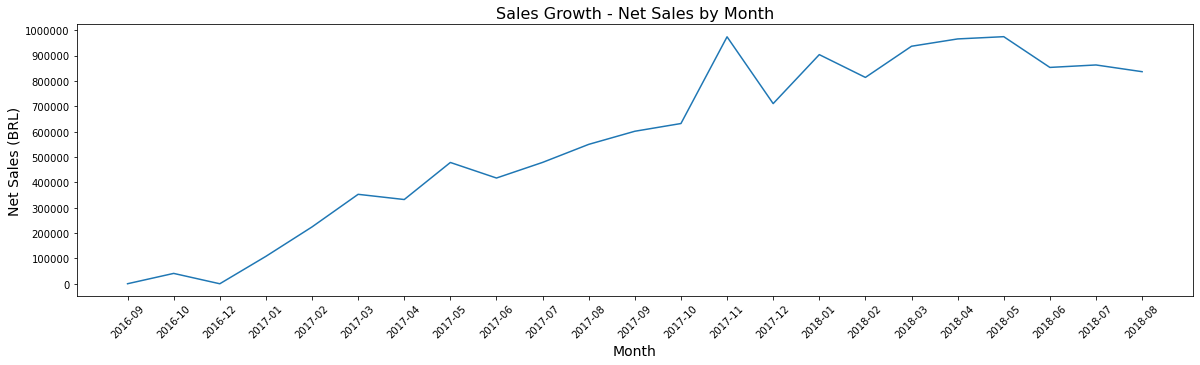

In [14]:
ticks = np.arange(0, 1000000 +1, 100000)
labels = ['{}'.format(v) for v in ticks]
plt.figure(figsize = (20,5))
sb.lineplot(data=net_month, x = 'month', y = 'price')
plt.yticks(ticks, labels)
plt.xticks(rotation = 45)
plt.title('Sales Growth - Net Sales by Month', fontsize = 16)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Net Sales (BRL)', fontsize = 14);

In [15]:
net_month

,month,price
0,2016-09,134.97
1,2016-10,40875.41
2,2016-12,10.90
3,2017-01,108174.83
4,2017-02,224167.74
5,2017-03,352741.68
6,2017-04,332221.49
7,2017-05,478340.91
8,2017-06,417020.97
9,2017-07,478636.66


Without knowing the parameters of the data sampling used to create the dataset, we cannot be certain of the accuracy of monthly totals, but we see a trend of rapid growth nonetheless. Even with sampled data, O-List reached 974,000 BRL (appx 186,000 USD) in net sales in a single month (11/2017) within roughly one year.

## Products

#### What are the top 10 categories by revenue?

In [16]:
#Group by product category, and sum item prices for a net sales total by category
cat_totals = df.groupby('product_category_name')['price'].sum()

In [17]:
#convert to dataframe and reset index
cat_totals = pd.DataFrame(cat_totals).reset_index()

In [18]:
#sort by totals, descending
cat_totals.sort_values(by='price', ascending=False, inplace=True)

In [19]:
#read in category translations
cat_trans = pd.read_csv('product_category_name_translation.csv')

In [20]:
#merge cat_totals with translations table
cat_totals = cat_totals.merge(cat_trans, on = 'product_category_name')

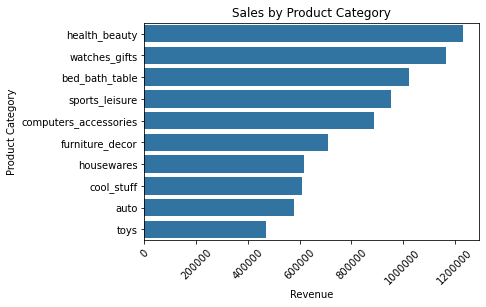

In [21]:
base_color = sb.color_palette()[0]
sb.barplot(data = cat_totals.head(10), y = 'product_category_name_english', x = 'price', color = base_color)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation = 45)
plt.ylabel('Product Category')
plt.xlabel('Revenue')
plt.title('Sales by Product Category');

**What are these 10 categories in percentage of overall net sales?**

In [22]:
cat_totals['%_of_total'] = cat_totals.price / cat_totals.price.sum() * 100

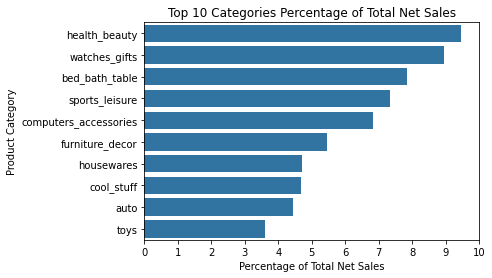

In [23]:
ticks = np.arange(0,10+0.1,1)
sb.barplot(data=cat_totals.head(10), y = 'product_category_name_english', x = '%_of_total', color = base_color)
plt.xticks(ticks)
plt.ylabel('Product Category')
plt.xlabel('Percentage of Total Net Sales')
plt.title('Top 10 Categories Percentage of Total Net Sales');

**Comparing Q1/Q2 2017 and Q1/Q2 2018, which categories have shown the most sales growth, and which have shown the most growth in unique skus sold?**  

In [24]:
#merge df with category translations table
#**we lose 22 rows with this inner merge**
df = df.merge(cat_trans, on = 'product_category_name')

In [25]:
#create new df - filter to include only orders from Q1/Q2 2017 and Q1/Q2 2018
df_quar = df.query('order_purchase_timestamp > 20170101 and order_purchase_timestamp < 20170701 or order_purchase_timestamp > 20180101 and order_purchase_timestamp < 20180701')

In [26]:
#add new column containing year from order_purchase_timestamp
df_quar['year'] = df_quar['order_purchase_timestamp'].dt.year

In [27]:
#total sales for each category by year
#group by category name, then year - sum price
df_sales = df_quar.groupby(['product_category_name_english','year'])['price'].sum()

In [28]:
#convert series to dataframe
df_sales = pd.DataFrame(df_sales)

In [29]:
#pivot dataframe - product category as index, year as columns and payment_value sums as values
df_sales = df_sales.pivot_table(values = 'price', index = 'product_category_name_english', columns = 'year').rename_axis(columns = None).reset_index()

In [30]:
#convert back to dataframe
df_sales = pd.DataFrame(df_sales.to_records())

In [31]:
#drop index
df_sales.drop('index', axis = 1, inplace=True)

In [32]:
#rename columns
df_sales.rename(columns = {'2017':'Q1Q2_2017_sales','2018':'Q1Q2_2018_sales'}, inplace=True)

In [33]:
#new feature - sales growth percentage - 2018 vs 2017
df_sales['sales_growth_%'] = (df_sales['Q1Q2_2018_sales'] - df_sales['Q1Q2_2017_sales']) / df_sales['Q1Q2_2017_sales'] *100

In [34]:
#sort rows by growth % - descending
df_sales.sort_values(by='sales_growth_%', ascending = False, inplace=True)

In [35]:
#count of unique product ids sold by category, then year
#group by product category, then year - count of unique product id's
df_skus = df_quar.groupby(['product_category_name_english','year'])['product_id'].nunique()

In [36]:
#convert series to dataframe and reset index
df_skus = pd.DataFrame(df_skus).reset_index()

In [37]:
#pivot dataframe - product category as index, year as columns and product_id count as values
df_skus = df_skus.pivot_table(values = 'product_id', index = 'product_category_name_english', columns = 'year').rename_axis(columns = None).reset_index()

In [38]:
#convert back to dataframe
df_skus = pd.DataFrame(df_skus.to_records())

In [39]:
#drop index
df_skus.drop('index', axis = 1, inplace=True)

In [40]:
#rename columns
df_skus.rename(columns = {'2017':'Q1Q2_2017_sku_count','2018':'Q1Q2_2018_sku_count'}, inplace=True)

In [41]:
#new feature - unique skus sold growth % - 2018 vs 2017
df_skus['sku_growth_%'] = (df_skus['Q1Q2_2018_sku_count'] - df_skus['Q1Q2_2017_sku_count']) / df_skus['Q1Q2_2017_sku_count'] * 100

In [42]:
#fill NaN values with 0
df_skus['Q1Q2_2017_sku_count'].fillna(0, inplace=True)
df_skus['Q1Q2_2018_sku_count'].fillna(0, inplace=True)

In [43]:
#convert dtypes to int
df_skus[['Q1Q2_2017_sku_count','Q1Q2_2018_sku_count']] = df_skus[['Q1Q2_2017_sku_count','Q1Q2_2018_sku_count']].astype('int')

In [44]:
combined = df_sales.merge(df_skus, on = 'product_category_name_english')

In [45]:
combined_melt = pd.melt(combined.head(10)[1:], id_vars = ['product_category_name_english'], value_vars = ['sales_growth_%','sku_growth_%',], var_name = 'growths', value_name = '%s' )

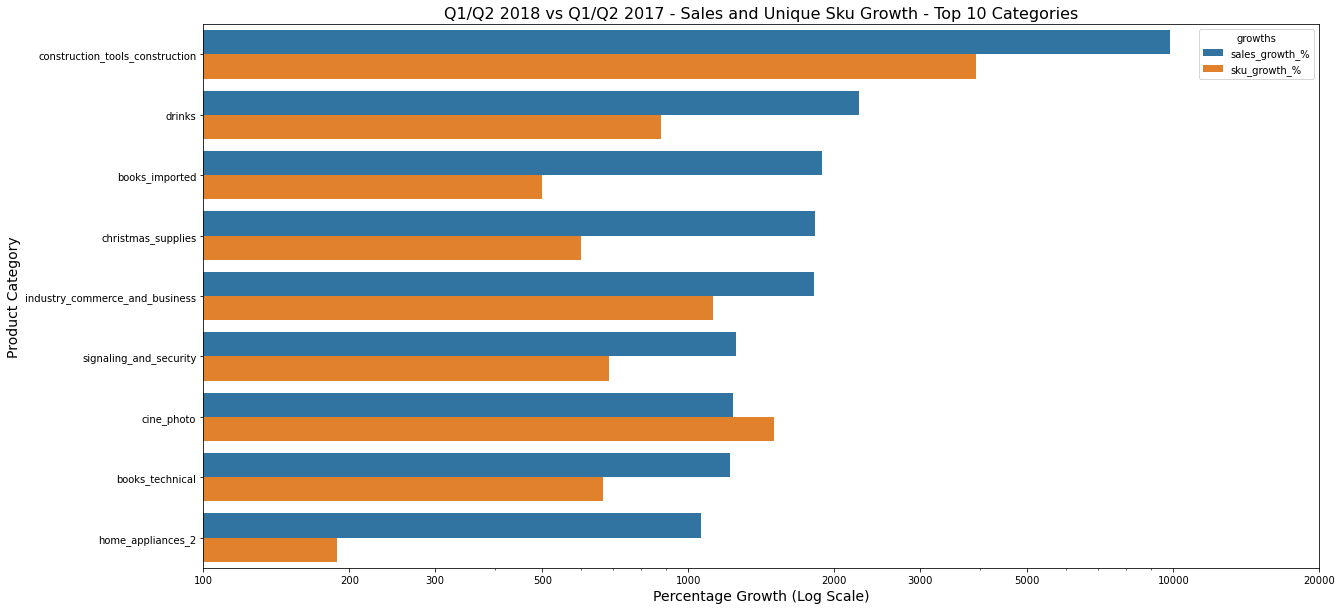

In [46]:
plt.figure(figsize = (20,10))
ticks = [100,200,300,500,1000,2000,3000,5000,10000,20000]
labels = ['{}'.format(v) for v in ticks]
sb.barplot(data=combined_melt, x = '%s', y = 'product_category_name_english', hue = 'growths')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Percentage Growth (Log Scale)', fontsize = 14)
plt.ylabel('Product Category', fontsize = 14)
plt.title('Q1/Q2 2018 vs Q1/Q2 2017 - Sales and Unique Sku Growth - Top 10 Categories', fontsize = 16);

## Customers

**What is the average order total, and the distribution of order totals?**

In [47]:
#create column for sum of item price and item freight
df['item_with_freight'] = df['price'] + df['freight_value']

In [48]:
#create new series with order total for each order
#group by order_id, sum 'item_with_freight' for each order
order_totals = df.groupby('order_id')['item_with_freight'].sum()

In [49]:
#convert series to dataframe and reset index
order_totals = pd.DataFrame(order_totals).reset_index()

In [50]:
#rename column
order_totals.rename(columns = {'item_with_freight':'order_total'}, inplace=True)

In [51]:
#descriptive summary, includes mean order total
order_totals.describe()

,order_total
count,95110.000000
mean,159.938445
std,218.637110
min,9.590000
25%,61.980000
50%,105.145000
75%,176.810000
max,13664.080000


In [52]:
#descriptive summary in log10 format for use in log scale plot bins
np.log10(order_totals.describe())

,order_total
count,4.978226
mean,2.203953
std,2.339724
min,0.981819
25%,1.792252
50%,2.021789
75%,2.247507
max,4.135580


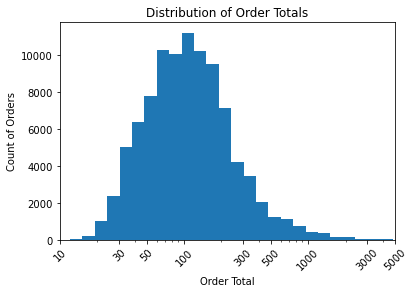

In [53]:
bins = 10 ** np.arange(0.98,4.13 +0.1, 0.1)
ticks = [10,30,50,100,300,500,1000,3000,5000]
labels = ['{}'.format(v) for v in ticks]
plt.hist(data=order_totals, x = 'order_total', bins = bins)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xticks(rotation = 45)
plt.title('Distribution of Order Totals')
plt.ylabel('Count of Orders')
plt.xlabel('Order Total')
plt.xlim((10,5000));

**What can we learn about returning customers?**

In [54]:
#Number of customer_unique_ids - the true unique id. This is the accurate count of unique customers
df['customer_unique_id'].nunique()

92063

In [55]:
#count of orders per unique customer
#group by customer_unique_id, number of unique order_ids per customer
repeat = df.groupby('customer_unique_id')['order_id'].nunique()

In [56]:
#convert series to dataframe and reset index
repeat = pd.DataFrame(repeat).reset_index()

In [57]:
#rename column
repeat.rename(columns={'order_id':'order_count'}, inplace=True)

In [58]:
#create new boolean column - true if more than 1 order for customer
repeat['repeat'] = repeat.order_count > 1

In [59]:
#count of non-repeat and repeat customers
repeat['repeat'].value_counts()

False    89322
True      2741
Name: repeat, dtype: int64

In [60]:
#Return customer rate
#number of repeat customers divided by number of unique customers
repeat[repeat['repeat'] == True]['customer_unique_id'].nunique() / repeat['customer_unique_id'].nunique() 

0.029773090166516407

In [61]:
#add the 'repeat' identifier to df to explore metrics related to repeat customers
df2 = df.merge(repeat, on = 'customer_unique_id', how = 'outer')

In [62]:
#number of orders placed by repeat customers
df2.query('repeat == True')['order_id'].nunique()

5788

In [63]:
#percentage of orders placed by repeat customers
df2.query('repeat == True')['order_id'].nunique() / df['order_id'].nunique()

0.06085585111975607

In [64]:
#total sales from repeat customers
df2.query('repeat == True')['price'].sum()

714669.3

In [65]:
#percentage of sales from repeat customers
df2.query('repeat == True')['price'].sum() / df['price'].sum()

0.054800908167732365

There seems to be a very low number of repeat customers - only 3%. Only 6% of orders were placed by repeat customers, with only 5% of sales coming from this segment. I'd like to explore some service related factors that might provide some insight as to why so few customers returned; payment approval time, days to fulfill, shipping time and price/freight ratio.

In [66]:
df2['approval_time'] = df2['order_approved_at'] - df2['order_purchase_timestamp']

In [67]:
df2['fulfill_time'] = df2['order_delivered_carrier_date'] - df2['order_approved_at']

In [68]:
df2['deliver_time'] = df2['order_delivered_customer_date'] - df2['order_delivered_carrier_date']

In [69]:
df2['estimate_time'] = df2['order_estimated_delivery_date'] - df2['order_purchase_timestamp']

In [70]:
df2['freight_%_total'] = df2['freight_value'] / df2['item_with_freight']

In [71]:
#descriptive summary for repeat customers
df2.query('repeat == True')[['approval_time','fulfill_time','deliver_time','estimate_time','freight_%_total']].describe()

,approval_time,fulfill_time,deliver_time,estimate_time,freight_%_total
count,7056,7056,7056,7056,7056.000000
mean,0 days 10:24:46.990079365,2 days 22:40:20.445719954,8 days 18:35:55.941184806,24 days 08:36:38.979024944,0.222879
std,0 days 20:18:43.388154034,3 days 09:48:42.151328407,7 days 13:06:33.767816856,9 days 01:04:20.322492017,0.132686
min,0 days 00:00:00,-10 days +20:04:04,-2 days +23:32:09,2 days 00:11:32,0.000000
25%,0 days 00:12:45,0 days 22:31:14.750000,4 days 00:30:18.750000,19 days 00:04:51,0.124360
50%,0 days 00:20:34.500000,1 days 23:05:08.500000,6 days 23:43:38.500000,23 days 09:54:51,0.192810
75%,0 days 15:13:15.750000,3 days 20:29:57.500000,11 days 07:23:11.250000,28 days 23:05:06.750000,0.297942
max,12 days 01:35:49,55 days 22:27:28,82 days 18:39:11,140 days 01:31:24,0.833472


In [72]:
#descriptive summary for non-repeat customers
df2.query('repeat == False')[['approval_time','fulfill_time','deliver_time','estimate_time','freight_%_total']].describe()

,approval_time,fulfill_time,deliver_time,estimate_time,freight_%_total
count,101565,101565,101565,101565,101565.000000
mean,0 days 10:32:01.878718062,2 days 19:58:36.543504159,9 days 05:15:24.908984408,23 days 18:30:30.012967091,0.212857
std,0 days 21:03:02.777404761,3 days 13:39:11.449074927,8 days 16:35:57.988318339,8 days 19:45:26.012393744,0.128836
min,0 days 00:00:00,-172 days +18:44:38,-17 days +21:41:31,2 days 00:15:03,0.000000
25%,0 days 00:13:01,0 days 21:00:04,4 days 01:36:56,18 days 08:11:53,0.118444
50%,0 days 00:21:06,1 days 19:46:47,7 days 01:32:00,23 days 05:37:46,0.187684
75%,0 days 15:10:45,3 days 14:37:23,11 days 22:27:56,28 days 10:33:26,0.281394
max,30 days 21:26:37,107 days 01:16:38,205 days 04:35:00,155 days 03:15:04,0.963283


Overall, the average approval, fulfillment, delivery and estimate times are roughly the same across both segments. Repeat customers spend about the same on shipping relative to item price, as non-repeat customers. That said, the average order for both groups sees about 22% of the order total going toward shipping, which is high.

## Sellers and Marketing

As the seller base is a key component of the platform, I'd like to explore how much the seller base has grown, and investigate the impact of marketing campaigns aimed at onboarding new sellers.

**How has the seller base grown over time?**

In [73]:
#redefine order_purchase_timestamp to include date only for the purpose of plotting timeseries
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].dt.date

In [74]:
#count of unique sellers per day
#group by order_purchase_timestamp (date), number of unique seller_ids per day
sellers_growth = df.groupby('order_purchase_timestamp')['seller_id'].nunique()

In [75]:
#convert series to dataframe and reset index
sellers_growth = pd.DataFrame(sellers_growth).reset_index()

In [76]:
#rename seller_id column to seller_count
sellers_growth.rename(columns={'seller_id':'seller_count'}, inplace=True)

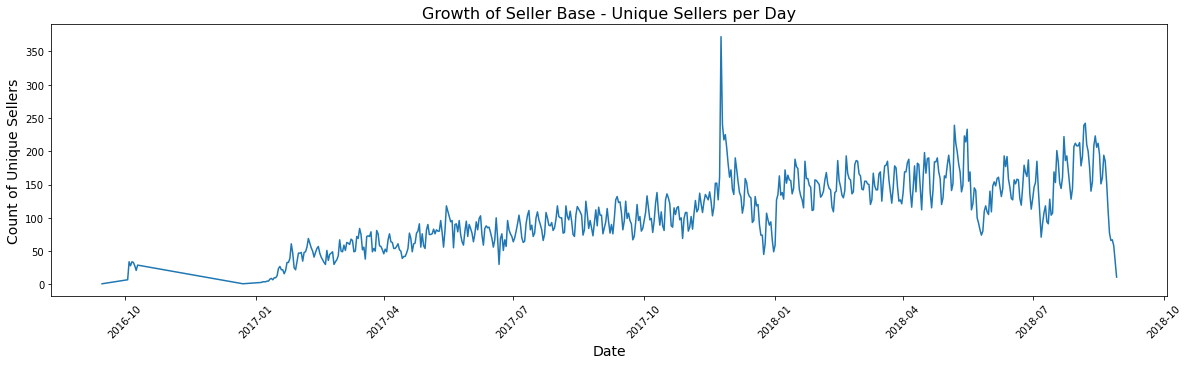

In [77]:
plt.figure(figsize = (20, 5))
sb.lineplot(data=sellers_growth, x = 'order_purchase_timestamp', y = 'seller_count')
plt.xticks(rotation = 45)
plt.title('Growth of Seller Base - Unique Sellers per Day', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Count of Unique Sellers', fontsize = 14);

We see steady growth of the O-List seller base through the end of dataset's available data, with a clear peak around Christmas of 2017.   

Keeping in mind that there were marketing campaigns to onboard new sellers, let's take a look at the impact of these marketing campaigns. 

**What has been the impact of marketing campaigns aimed at onboarding new sellers? Have these campaigns been successful?**

In [78]:
#create a list of mql onboarded sellers - for use in membership query to segment sellers by mql only
mql_sellers =[]
for i in closed_deals['seller_id']:
    mql_sellers.append(i)
    

In [79]:
#df containing only sellers who were included in the closed deals dataset ie mql sellers
mql_onboarded = df[df['seller_id'].isin(mql_sellers) == True]

In [80]:
#number of unique mql sellers selling per day
#group by order_purchase_timestamp (date), count of unique seller id's
selling_mql = mql_onboarded.groupby('order_purchase_timestamp')['seller_id'].nunique()

In [81]:
#convert series to dataframe and reset index
selling_mql = pd.DataFrame(selling_mql).reset_index()

In [82]:
#gross sales from mql sellers per day
#group by order_purchase_timestamp (date), sum of item_with_freight
sales_mql = mql_onboarded.groupby('order_purchase_timestamp')['item_with_freight'].sum()

In [83]:
#convert series to dataframe and reset index
sales_mql = pd.DataFrame(sales_mql).reset_index()

In [84]:
#overall gross sales per day
#group by order_purchase_timestamp (date), sum of item_with_freight
total_sales = df.groupby('order_purchase_timestamp')['item_with_freight'].sum()

In [85]:
#convrt series to dataframe and reset index
total_sales = pd.DataFrame(total_sales).reset_index()

In [86]:
#new dataframe to combine sales_mql and total_sales
mql_proportion = sales_mql.merge(total_sales, on = 'order_purchase_timestamp', how = 'left')

In [87]:
#new column for mql proportion of overall gross by day
mql_proportion['mql_proportion'] = mql_proportion['item_with_freight_x'] / mql_proportion['item_with_freight_y'] * 100

In [88]:
#convert won_date to datetime
closed_deals['won_date'] = pd.to_datetime(closed_deals['won_date'])

In [89]:
#redefine won_date to include only date for use in plotting timeseries
closed_deals['won_date'] = closed_deals['won_date'].dt.date

In [90]:
#number of deals closed by date
#group by won_date, count of unique seller id's
closed_dates = closed_deals.groupby('won_date')['seller_id'].nunique()

In [91]:
#convert series to dataframe and reset index
closed_dates = pd.DataFrame(closed_dates).reset_index()

In [92]:
#rename columns
closed_dates.rename(columns={'won_date':'date','seller_id':'deals_closed'}, inplace=True)

In [93]:
#An expanding sum of sellers onboarded over time
closed_dates['sellers_onboarded'] = closed_dates['deals_closed'].expanding(2).sum()

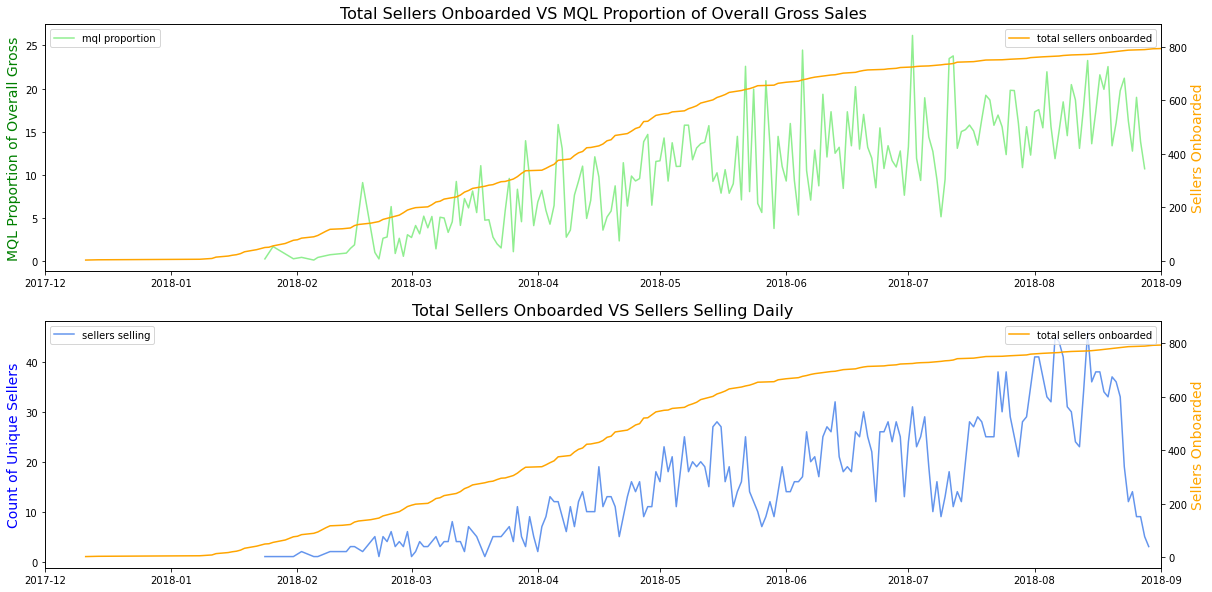

In [94]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sb.lineplot(data=mql_proportion[:-1], x = 'order_purchase_timestamp', y = 'mql_proportion', label = 'mql proportion', color = 'lightgreen')
plt.legend(loc='upper left')
plt.xlim(('2018-01','2018-09'))
plt.ylabel('MQL Proportion of Overall Gross', fontsize = 14, color = 'g')
plt.xlabel('')
plt.title('Total Sellers Onboarded VS MQL Proportion of Overall Gross Sales', fontsize = 16)
ax2 = plt.twinx()
sb.lineplot(data=closed_dates, x = 'date', y = 'sellers_onboarded', ax=ax2, label = 'total sellers onboarded', color = 'orange')
plt.legend(loc = 'upper right')
plt.ylabel('Sellers Onboarded', fontsize = 14, color = 'orange')
plt.xlim(('2017-12','2018-09'))
plt.subplot(2,1,2)
sb.lineplot(data=selling_mql, x = 'order_purchase_timestamp', y = 'seller_id', label = 'sellers selling', color = 'cornflowerblue')
plt.xlim(('2018-01','2018-09'))
plt.ylabel('Count of Unique Sellers', fontsize = 14, color = 'b')
plt.xlabel('')
plt.title('Total Sellers Onboarded VS Sellers Selling Daily', fontsize = 16)
ax2 = plt.twinx()
sb.lineplot(data=closed_dates, x = 'date', y = 'sellers_onboarded', ax=ax2, label = 'total sellers onboarded', color = 'orange')
plt.ylabel('Sellers Onboarded',fontsize = 14, color = 'orange')
plt.xlim(('2017-12','2018-09'));

We see that, as the total number of sellers onboaded increases, mql sales account for a larger and larger proportion of overall gross sales. The peak is appx 25%. It appears that the marketing campaigns are certainly having a significant amount of success in their contribition to overall revenue.

It's surprising to see such a low number of unique sellers per day relative to how many sellers have been onboarded via marketing campaigns. For example, as the total number of deals closed exceeded 600, there was a peak of only appx 25 unique sellers selling product per day, or 4.2% of onboarded sellers. However, as the total number of onboarded sellers exceeded 750, we see a peak of appx 45 unique sellers, or 6%. This suggests there is a signifcant lag time from deal close date to first order date.

Still, the percentage of onboarded sellers who are actually selling seems quite low, but I'd like to explore the average time between deal close and first sale, and explore in detail the closed-to-sales ratio.


**What is the average deal-close to first-order time range? And the distribution?**

In [95]:
#the earliest order date for each unique seller_id
mql_first = mql_onboarded.groupby('seller_id')['order_purchase_timestamp'].min()

In [96]:
#convert series to dataframe and reset index
mql_first = pd.DataFrame(mql_first).reset_index()

In [97]:
#merge earliest order dates with closed_deals dataset
mql_dates = mql_first.merge(closed_deals, on = 'seller_id')

In [98]:
#numbers of days between deal closed date to first order date
#order_purchase_timestamp - won_date
mql_dates['days_to_sales'] = mql_dates['order_purchase_timestamp'] - mql_dates['won_date']

In [99]:
#isolate number
#convert from datetime to string, isolate number(s), convert to integer
mql_dates['days_to_sales'] = mql_dates['days_to_sales'].astype('str').str[:-5].astype(int)

In [100]:
#descriptive summary; includes mean days to sales
mql_dates.days_to_sales.describe()

count    373.000000
mean      51.731903
std       35.989290
min        3.000000
25%       23.000000
50%       44.000000
75%       72.000000
max      189.000000
Name: days_to_sales, dtype: float64

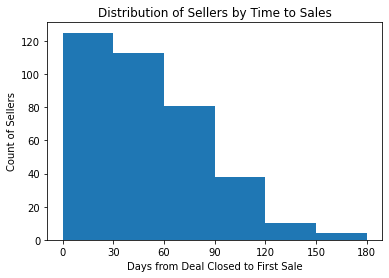

In [101]:
bins = np.arange(0,190,30)
ticks = np.arange(0,190,30)
labels = ['{}'.format(v) for v in ticks]
plt.hist(data=mql_dates, x = 'days_to_sales', bins = bins)
plt.xticks(ticks, labels)
plt.title('Distribution of Sellers by Time to Sales')
plt.xlabel('Days from Deal Closed to First Sale')
plt.ylabel('Count of Sellers');

**How many onboarded sellers have actually begun to sell on the platform?**

In [102]:
mql_onboarded.seller_id.nunique()

373

**And what is the percentage of onboarded sellers who have begun to sell?**

In [103]:
mql_onboarded.seller_id.nunique() / closed_deals.seller_id.nunique()

0.44299287410926363

**How much revenue is generated per deal for each lead type?**

In [104]:
#merge mql_onboarded df with closed_deals df - inner merge on seller_id
mql_lead_type = mql_onboarded.merge(closed_deals, on = 'seller_id')

In [105]:
#gross sales for each lead type
#group by lead_type, sum of item_with_freight
sales_per_type = mql_lead_type.groupby('lead_type')['item_with_freight'].sum()

In [106]:
#convert series to dataframe and reset index
sales_per_type = pd.DataFrame(sales_per_type).reset_index()

In [107]:
#number of deals closed per lead type
#group by lead_type, number of unique seller id's
deals_per_type = closed_deals.groupby('lead_type')['seller_id'].nunique()

In [108]:
#convert series to dataframe and reset index
deals_per_type = pd.DataFrame(deals_per_type).reset_index()

In [109]:
#merge deals_per_type with sales_per_type
sales_per_deal = deals_per_type.merge(sales_per_type, on = 'lead_type', how = 'outer')

In [110]:
#fill NaN values with zeroes
sales_per_deal.fillna(0, inplace=True)

In [111]:
#mean gross sales per deal closed
#sales_per_deal = item_with_freight divided by seller_id (count of seller id's)
sales_per_deal['sales_per_deal'] = sales_per_deal['item_with_freight'] / sales_per_deal['seller_id']

In [112]:
#sort values descending by sales_per_deal
sales_per_deal.sort_values(by = 'sales_per_deal', ascending = False, inplace=True)

In [113]:
sales_per_deal

,lead_type,seller_id,item_with_freight,sales_per_deal
3,online_big,126,321747.53,2553.551825
5,online_small,77,60183.52,781.604156
4,online_medium,332,235683.66,709.890542
6,online_top,14,9337.33,666.952143
2,online_beginner,57,25745.79,451.680526
0,industry,123,36117.63,293.639268
1,offline,104,22165.76,213.132308
7,other,3,0.00,0.000000


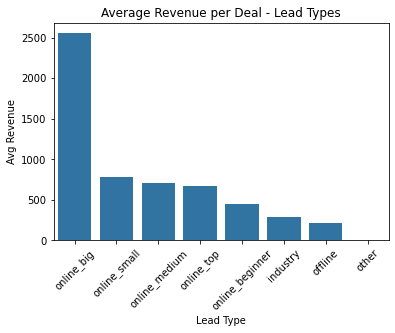

In [114]:
color = sb.color_palette()[0]
sb.barplot(data=sales_per_deal, x = 'lead_type', y = 'sales_per_deal', color = color)
plt.xticks(rotation = 45)
plt.title('Average Revenue per Deal - Lead Types')
plt.ylabel('Avg Revenue')
plt.xlabel('Lead Type');

**What is the average revenue per deal over time?**

In [115]:
#merge mql_onboarded with closed_deals, inner merge on seller_id
sales_deals_mql = mql_onboarded.merge(closed_deals, on = 'seller_id')

In [116]:
#rename column
sales_deals_mql.rename(columns = {'order_purchase_timestamp':'date'}, inplace = True)

In [117]:
#new df, sort by seller_id, then date, ascending for both
days = sales_deals_mql.sort_values(by = ['seller_id', 'date'], ascending = (True, True))

In [118]:
#convert date and won_date to datatime
days[['date','won_date']] = days[['date','won_date']].apply(pd.to_datetime)

In [119]:
#days between won_date and order_purchase_timestamp
#date (order_purchase_timestamp) - won_date
#isolate number
#convert from datetime to string, isolate number(s), convert to integer
days['time'] = (days['date'] - days['won_date']).astype(str).str[:-5].astype(int)

In [120]:
#list of time intervals
intervals = [30,60,90,120,150,180]
#empty list of means
means = []
#loop that produces the mean gross sales for each time segment, appends mean to means list
for i in intervals:
    mean = days.query('time < {}'.format(i)).groupby('seller_id')['item_with_freight'].sum().mean()
    means.append(mean)

In [121]:
#dictonary comprehension; creates dictionary from lists
averages = dict(zip(intervals, means))

In [122]:
#create dataframe from dictionary
averages = pd.DataFrame.from_dict(averages, orient = 'index', columns = ['avg_revenue']).reset_index()

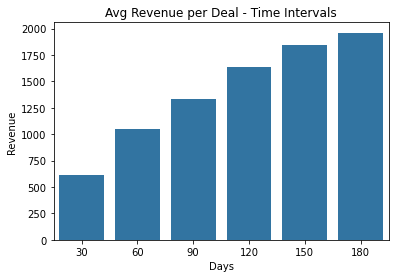

In [123]:
color = sb.color_palette()[0]
sb.barplot(data=averages, x = 'index', y = 'avg_revenue', color = color)
plt.xlabel('Days')
plt.ylabel('Revenue')
plt.title('Avg Revenue per Deal - Time Intervals');

While the data on MQL onboarded sellers is limited, we can see that only half of onboarded sellers actually began to sell. Exploring the performance of these sellers more deeply provides insight as to how long a seller typically takes to begin selling, how much revenue is generated by the average seller over time, and which lead types perform better or worse than others.

### Summary and conclusions
The dataset explored here was sampled from the very early days of the O-List platform. The data reveales that roughly a quarter of the company's revenue is generated by its top three categories. Substantial growth of newer categories is observed as new items were added to the site's assortment, and consistent growth of the O-List seller base occurred both organically and as a result of marketing campaigns.

In regards to marketing campaigns, it seems that more follow up and guidance by sales staff on newly closed deals might help increase the number of onboarded sellers who begin to sell, which of course would increase average revenue per deal closed. Observing the time-to-sales distribution combined with revenue over time and revenue per lead type, insight is gained in what type of companies to target, and a reasonable forecast of marketing results becomes possible.